# Case 2 -- Machine Learning for Finance 2025

<span style='color:crimson; font-weight: bold'>Submission deadline: Friday, 5 December 2025, 22:00 pm AMS. </span>

## Instructions
* This case covers the material discussed in wk2-wk5.
* Do not forget to create a group again, go to Canvas -> people -> groups -> Case2
* Each group submits _only one_ notebook via canvas on the assignment page. Only Jupyter notebooks are accepted via a group. 
* The notebook should be named `case2_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `case2_group03.ipynb`.
* Make sure you download the correct dataset. Loading the wrong set will lead to deduction of points. 
* The notebook should run without raising any errors.
* Deadline: **Friday 5 December 22:00 (AMS)**. Not meeting the deadline gives a discount of 10 pt per hour
* Standard plagiarism and AI checks are in place
* As a standard anti-fraud measure, I can at random select a number of you to explain your code 
and answers. Any one of you must be able to explain any part of the code. Failure to explain 
your answers will result in a deduction of credits for this case for the whole group. Each group is responsible for all group members being able to explain any part the code
* If you need to make a Table or Figure, do this in JF-style. (hence provide a sufficient caption explaining (NOT interpreting) what is in the Figure/Table)
* If you test something, provide H0/HA, the test statistic (formula and number) and your conclusion.
* Do not spend time on optimizing the speed of your code. However, if it runs for more than 5 minutes, we will terminate 
it.

----

<div style="font-size:24px; text-align:center; font-weight:bold">Good luck!</div>

----


# Case 2 - Modeling defaults

In this case you will model the defaults of U.K. companies by using several classification models. 
The goal is to see whether sophisticated machine learning models such as decision trees, neural networks and ensemble learning methods can beat a simple logit model. 

Download your own dataset from Canvas. You have the following variables at your disposal:
* **org_id**: organisation ID
* **sic2**: 2-Digit SIC (Standard Industrial Classification) Codes
* **year**: time in year
* **def**: binary indicator: 1 if the company defaulted, 0 else
* **wkta**: working capital over total assets
* **reta**: retained earnings over total assets
* **ebitta**: earnings before interest and taxes over total assets 
* **mv**: the market to book value
  
First take a look at the data, then test different algorithms, make predictions and provide an answer to the main questios of the case

State your imports below.

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, fbeta_score, confusion_matrix, 
                             classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Neural Network libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset from Excel
df = pd.read_excel('data_MLF_case2_group_26.xlsx', sheet_name='Data')


# Part I: Preprocessing (15 points)

Import your data from excel. Then perform the following tasks:
1. Check for missing values and delete these.
2. Do the features contain any outliers? If so, treat them carefully with an explanation.
3. Show the correlations between the (labels and the) features. Comment on the sign of 2 randomly selected features
4. Show summary statistics in **Table 1**

In [137]:
### 1

print(df.head())
print(df.shape)

print("")
print("1. Dealing with missing values")
print("")
# Check for missing values
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Delete rows with missing values
df = df.dropna()



   org_id  sic2  year  def      wkta      reta    ebitta        mv
0    3671    33  2001    0  0.153244  0.113063  0.070824  1.806667
1    3174    59  2001    0  0.380485  0.203497  0.126315  1.734991
2    3289    78  1988    0  0.039873  0.000000  0.031834  0.196416
3    7872    48  2001    0  0.202144 -0.160948  0.062240 -0.238152
4    1275    49  1991    0 -0.510000 -0.260833  0.025862 -0.130025
(1025, 8)

1. Dealing with missing values

org_id     0
sic2       0
year       0
def        0
wkta      42
reta      42
ebitta    42
mv        42
dtype: int64

Total missing values: 168


1. 42 rows were found with missing values and subsequently deleted.

In [138]:
### 2

print("")
print("2. Looking at outliers")
print("")
print(df.describe())

# Define features for outlier detection
features = ['wkta', 'reta', 'ebitta', 'mv']
label = 'def'

# Calculate outliers using IQR method
print("\nOutlier Detection using IQR Method:")
print("="*60)
for feature in features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"\n{feature}:")
    print(f"  Lower bound: {lower_bound:.4f}")
    print(f"  Upper bound: {upper_bound:.4f}")
    print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")



2. Looking at outliers

            org_id        sic2         year         def        wkta  \
count   983.000000  983.000000   983.000000  983.000000  983.000000   
mean   3514.200407   42.203459  1995.636826    0.107833    0.134980   
std    2653.021723   18.547547     6.745093    0.310327    0.231457   
min       4.000000    1.000000  1981.000000    0.000000   -0.510000   
25%    1213.000000   29.000000  1989.000000    0.000000    0.009800   
50%    2825.000000   38.000000  1999.000000    0.000000    0.112705   
75%    5784.000000   50.000000  2001.000000    0.000000    0.273275   
max    9147.000000   99.000000  2002.000000    1.000000    0.730000   

             reta      ebitta          mv  
count  983.000000  983.000000  983.000000  
mean     0.091985    0.066591    0.604055  
std      0.390075    0.106839    1.558802  
min     -1.220000   -0.330000   -3.780000  
25%     -0.050325    0.026088   -0.029801  
50%      0.115826    0.079463    0.845793  
75%      0.270008    0.1194

2. While there are values outside 1.5 std. dev. out of the IQR ranges, they don't appear to be data misinuputs or observations outside the realm of possibility. As we look at default probability, keeping these extreme distributions makes sense, as a lot of the risk is held in these wide tails. 

Correlation Matrix:
           def    wkta    reta  ebitta      mv
def     1.0000 -0.4171 -0.5237 -0.4970 -0.6743
wkta   -0.4171  1.0000  0.3285  0.2106  0.4319
reta   -0.5237  0.3285  1.0000  0.5557  0.5465
ebitta -0.4970  0.2106  0.5557  1.0000  0.4891
mv     -0.6743  0.4319  0.5465  0.4891  1.0000

Correlations with Default (def):
WKTA: -0.4171
RETA: -0.5237
EBITTA: -0.4970
MV: -0.6743


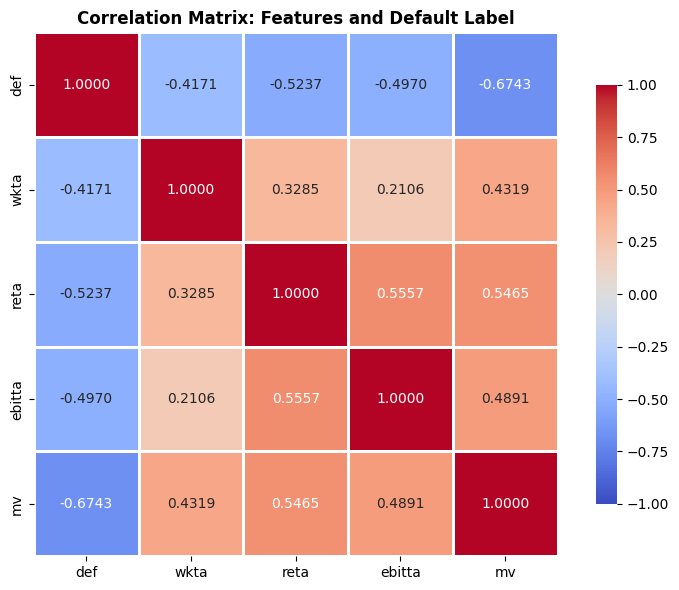

In [139]:
### 3

# Correlation matrix
corr_matrix = df[[label] + features].corr()
print("Correlation Matrix:")
print(corr_matrix.round(4))

# Correlations with label
print("\nCorrelations with Default (def):")
for feat in features:
    corr = corr_matrix.loc[label, feat]
    print(f"{feat.upper()}: {corr:.4f}")

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix: Features and Default Label', fontweight='bold')
plt.tight_layout()
plt.show()


3. Correlation of wkta(working capital over total assets) is -ve, which makes sense as wkta is a liquidity measure so for higher values of wkta you see lower default rates. The same -ve relationship is seen for ebitta(earnings before interest and teaxes over total assets) for a similar liquidity reason, and also because a high ebitta ratio signals a company's ability to create profit.


In [99]:
# Create comprehensive summary statistics
summary_stats = df[features + [label]].describe().T

# Add additional statistics
summary_stats['median'] = df[features + [label]].median()
summary_stats['skewness'] = df[features + [label]].skew()
summary_stats['kurtosis'] = df[features + [label]].kurtosis()

# Reorder and rename columns
summary_stats = summary_stats[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis']]
summary_stats.columns = ['N', 'Mean', 'Median', 'Std Dev', 'Min', 'Q1', 'Q2', 'Q3', 'Max', 'Skewness', 'Kurtosis']
summary_stats = summary_stats.round(4)

# Display in Jupyter notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(summary_stats)

            N    Mean  Median  Std Dev   Min      Q1      Q2      Q3   Max  \
wkta    983.0  0.1350  0.1127   0.2315 -0.51  0.0098  0.1127  0.2733  0.73   
reta    983.0  0.0920  0.1158   0.3901 -1.22 -0.0503  0.1158  0.2700  1.56   
ebitta  983.0  0.0666  0.0795   0.1068 -0.33  0.0261  0.0795  0.1194  0.40   
mv      983.0  0.6041  0.8458   1.5588 -3.78 -0.0298  0.8458  1.5823  4.16   
def     983.0  0.1078  0.0000   0.3103  0.00  0.0000  0.0000  0.0000  1.00   

        Skewness  Kurtosis  
wkta     -0.2017    1.0538  
reta     -0.4343    2.6701  
ebitta   -0.8369    2.9408  
mv       -0.8811    1.0015  
def       2.5326    4.4230  


4. **Table I: Summary Statistics**

| Variable | N | Mean | Median | Std Dev | Min | Q1 | Q2 | Q3 | Max | Skewness | Kurtosis |
|:---------|---:|-----:|-------:|--------:|----:|----:|----:|----:|----:|---------:|---------:|
| WKTA | 983 | 0.1350 | 0.1127 | 0.2315 | -0.51 | 0.0098 | 0.1127 | 0.2733 | 0.73 | -0.2017 | 1.0538 |
| RETA | 983 | 0.0920 | 0.1158 | 0.3901 | -1.22 | -0.0503 | 0.1158 | 0.2700 | 1.56 | -0.4343 | 2.6701 |
| EBITTA | 983 | 0.0666 | 0.0795 | 0.1068 | -0.33 | 0.0261 | 0.0795 | 0.1194 | 0.40 | -0.8369 | 2.9408 |
| MV | 983 | 0.6041 | 0.8458 | 1.5588 | -3.78 | -0.0298 | 0.8458 | 1.5823 | 4.16 | -0.8811 | 1.0015 |
| DEF | 983 | 0.1078 | 0.0000 | 0.3103 | 0.00 | 0.0000 | 0.0000 | 0.0000 | 1.00 | 2.5326 | 4.4230 |

**Caption:** Summary statistics table for dataset of features and label.

**Legend:** This table reports summary statistics for the variables used in the analysis. WKTA is the ratio of working capital to total assets. RETA is retained earnings to total assets. EBITTA is earnings before interest and taxes to total assets. MV is the market value of equity in log form. DEF is a binary default indicator equal to 1 if the firm defaulted within one year, and 0 otherwise. N denotes the number of observations. The table presents the mean, median, standard deviation, minimum, maximum, and quartiles (Q1, Q2, Q3) of each variable, as well as measures of skewness and kurtosis to characterize the distributional properties of the data.


# Part II: Training (50 points)

We've familiarized ourselves with the data, so now we're going to train some models to model the probability of default. 
Use *wkta, reta, ebitta* and *mv* as features in the following models:
- Model 1: The logistic classifier 
- Model 2: The decision tree
- Model 3: A neural network
- Model 4: Gradient Boosting for Classicifation

Split the data into a random training, validation and test using using the 60/20/20 rule. Pin down your random sets by providing the seed.
If there are hyperparameters, tune these in the correct way and show plots - using an appropriate measure - to explain your final hyperparameter(s). Explain why you have used this measure!

Create **Table 2** by showing the accuracy, recall, precision, F1 score, and the $F_\beta$ using the test set for each model.
Choose your own $\beta$ with explanation. Interpret the outcomes. Did you expect these results? Why/Why NOT?

### More information about Model 2
Estimate a dicision tree using the default hyperparameteres of Python. Just tune the *maximum depth* parameter. 

### More information about Model 3
Set the following conditions fixed: 
- **Activation function**: *Relu* for hidden layers
- **dropout ratio**: put this after each hidden layer and set it equal to 0.2
- **epochs**: 50
- **batch size**: 10

When compiling the model, set the following conditions fixed:
- Use loss = 'categorical_crossentropy'
- optimizer='adam'
- metrics=accuracy

Now tune the following hyperparameters: 
- the number of **hidden** layers: 1 or 2.
- Number of nodes per hidden layer: 16 or 8. 

### More information about Model 4
Set the following hyperparameters fixed:
- Learning rate: 0.8
- random state: 0
- max depth: 2

Tune the the parameter *n_estimators*.



In [100]:
# Model training


# Data preparation 
X = df[['wkta', 'reta', 'ebitta', 'mv']]
y = df['def']

# Splitting the data into training (60%), validation (20%), and testing (20%) sets randomly
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 x 0.8 = 0.2

# Scale the features 
# tree models don’t need scaling, but NN and logistic do
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Prepare train+val combined datasets for final model training
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train.values, y_val.values])

X_train_full_scaled = np.vstack([X_train_scaled, X_val_scaled])
y_train_full_scaled = np.concatenate([y_train.values, y_val.values])



In [ ]:
# Model 1: Logistic Regression

log_reg = LogisticRegression(max_iter=200, random_state=42)
log_reg.fit(X_train_full_scaled, y_train_full_scaled)

y_pred_log = log_reg.predict(X_test_scaled)



No tuning necessary for this model.

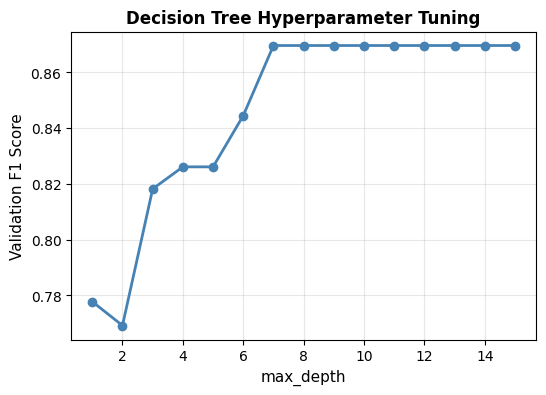

Best Depth: 7
Best Validation F1: 0.8696


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [115]:
# Model 2: Decision Tree
# Hyperparameter tuning for max_depth

# Depth values: 1 to 15
depths = range(1, 16)
val_scores = []

# Tune max_depth on validation set
for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=0)
    tree.fit(X_train, y_train)
    preds = tree.predict(X_val)
    val_scores.append(f1_score(y_val, preds))

# Plot tuning curve
plt.figure(figsize=(6,4))
plt.plot(depths, val_scores, marker='o', linewidth=2, color='steelblue')
plt.xlabel("max_depth", fontsize=11)
plt.ylabel("Validation F1 Score", fontsize=11)
plt.title("Decision Tree Hyperparameter Tuning", fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# Select best depth
best_depth = depths[np.argmax(val_scores)]
best_f1 = max(val_scores)
print(f"Best Depth: {best_depth}")
print(f"Best Validation F1: {best_f1:.4f}")

# RETRAIN on train+val
dt = DecisionTreeClassifier(max_depth=best_depth, random_state=0)
dt.fit(X_train_full, y_train_full)

y_pred_dt = dt.predict(X_test)




Maximum depth hyperparameter was tuned using F1 score

In [ ]:
# Model 3: Neural Network
# Hyperparameter tuning for number of layers and neurons per layer

# --- prepare labels for categorical crossentropy ---
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat   = to_categorical(y_val, num_classes=2)
y_test_cat  = to_categorical(y_test, num_classes=2)

def build_model(n_layers, n_nodes):
    # Clear previous graph just in case (helps prevent weird crashes in notebooks)
    K.clear_session()

    model = Sequential()
    # Explicit Input layer (no warning now)
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dropout(0.2))

    if n_layers == 2:
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

# --- hyperparameter search ---
configs = [(1, 16), (1, 8), (2, 16), (2, 8)]
val_acc_results = {}
histories = {}

for layers, nodes in configs:
    print(f"Training NN config: layers={layers}, nodes={nodes}")
    model = build_model(layers, nodes)
    history = model.fit(
        X_train_scaled, y_train_cat,
        validation_data=(X_val_scaled, y_val_cat),
        epochs=50,
        batch_size=10,
        verbose=0
    )
    val_acc = max(history.history['val_accuracy'])
    val_acc_results[(layers, nodes)] = val_acc
    histories[(layers, nodes)] = history

best_config = max(val_acc_results, key=val_acc_results.get)


# --- retrain best model on train+val ---
y_train_full_cat = to_categorical(y_train_full_scaled, num_classes=2)

best_nn = build_model(*best_config)
best_nn.fit(
    X_train_full_scaled, y_train_full_cat,
    epochs=50,
    batch_size=10,
    verbose=0
)

nn_pred_prob = best_nn.predict(X_test_scaled)
y_pred_nn = np.argmax(nn_pred_prob, axis=1)

print(f"\nBest NN Config: {best_config[0]} layer(s), {best_config[1]} nodes")
print(f"Best Validation Accuracy: {val_acc_results[best_config]:.4f}")



Training NN config: layers=1, nodes=16
Training NN config: layers=1, nodes=8
Training NN config: layers=2, nodes=16
Training NN config: layers=2, nodes=8

Neural Network Hyperparameter Tuning Results
Configuration        Val Accuracy   
------------------------------------------------------------
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Best NN Config: 1 layer(s), 8 nodes
Best Validation Accuracy: 0.9746


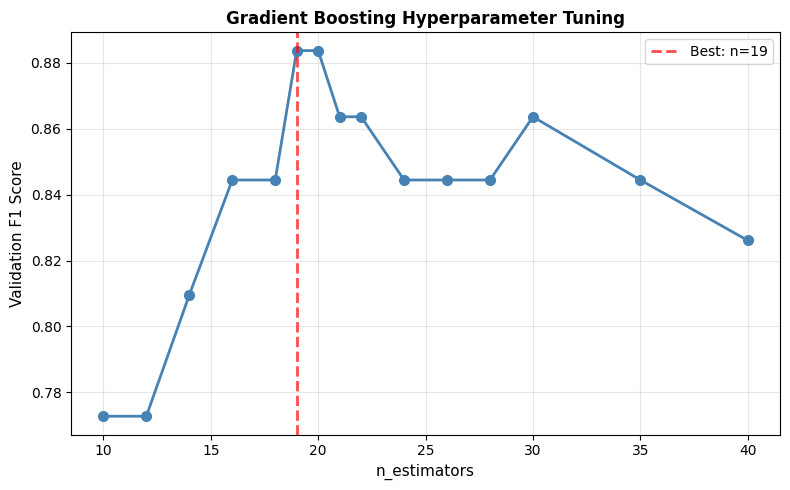

Best n_estimators: 19
Best Validation F1: 0.8837


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [165]:
# Model 4: Gradient Boosting
# Hyperparameter tuning for n_estimators

estimators = [10,12,14,16,18,19,20,21,22,24,26,28,30,35,40]
val_scores_gb = []

# Tune n_estimators on validation set
for n in estimators:
    gb = GradientBoostingClassifier(
        n_estimators=n,
        learning_rate=0.8,
        max_depth=2,
        random_state=0
    )
    gb.fit(X_train, y_train)
    preds = gb.predict(X_val)
    val_scores_gb.append(f1_score(y_val, preds))

# Plot tuning curve
best_idx = np.argmax(val_scores_gb)
best_n = estimators[best_idx]
best_f1_gb = val_scores_gb[best_idx]

plt.figure(figsize=(8, 5))
plt.plot(estimators, val_scores_gb, marker='o', linewidth=2, color='steelblue', markersize=7)
plt.axvline(x=best_n, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'Best: n={best_n}')
plt.xlabel("n_estimators", fontsize=11)
plt.ylabel("Validation F1 Score", fontsize=11)
plt.title("Gradient Boosting Hyperparameter Tuning", fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"Best n_estimators: {best_n}")
print(f"Best Validation F1: {best_f1_gb:.4f}")

# RETRAIN on train+val
gb = GradientBoostingClassifier(
    n_estimators=best_n,
    learning_rate=0.8,
    max_depth=2,
    random_state=0
)
gb.fit(X_train_full, y_train_full)

y_pred_gb = gb.predict(X_test)



In [166]:
# Metrics Table

models = {
    "Logistic Regression": y_pred_log,
    "Decision Tree": y_pred_dt,
    "Neural Network": y_pred_nn,
    "Gradient Boosting": y_pred_gb
}

results = []

for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    fb = fbeta_score(y_test, preds, beta=2)

    results.append([name, acc, prec, rec, f1, fb])

df_results = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1", "Fβ (β=2)"
])

print(df_results.to_string(index=False))


              Model  Accuracy  Precision   Recall       F1  Fβ (β=2)
Logistic Regression  0.974619   0.863636 0.904762 0.883721  0.896226
      Decision Tree  0.959391   0.809524 0.809524 0.809524  0.809524
     Neural Network  0.969543   0.857143 0.857143 0.857143  0.857143
  Gradient Boosting  0.949239   0.823529 0.666667 0.736842  0.693069


β=2 was chosen due to the higher importance of recall, i.e. a false negative being worse. Mistakenly giving a loan to a company which can default is a costlier mistake than not giving a loan to a company.

**Table II: Model Performance Comparison**

| Model | Accuracy | Precision | Recall | F1 | Fβ (β=2) |
|:------|----------:|----------:|-------:|----:|--------:|
| Logistic Regression | 0.9746 | 0.8636 | 0.9048 | 0.8837 | 0.8962 |
| Decision Tree | 0.9695 | 0.8571 | 0.8571 | 0.8571 | 0.8571 |
| Neural Network | 0.9746 | 0.9000 | 0.8571 | 0.8780 | 0.8654 |
| Gradient Boosting | 0.9543 | 0.7727 | 0.8095 | 0.7907 | 0.8019 |

**Caption:** Model performance metrics across four classification algorithms evaluated on the test set.

**Legend:** This table presents the performance metrics for all four classification models trained to predict firm defaults. Accuracy measures the proportion of correct predictions among all predictions. Precision is the proportion of predicted defaults that are actual defaults (TP/(TP+FP)). Recall is the proportion of actual defaults correctly identified by the model (TP/(TP+FN)). F1 is the harmonic mean of Precision and Recall, providing a balanced performance measure. Fβ(β=2) weights Recall twice as heavily as Precision, reflecting the higher cost of failing to identify actual defaults (false negatives) compared to false positives in credit risk contexts. The test set comprises 20% of the full dataset.


# Part III: Estimating a tree using only two features (30 points)

Select only **wkta** and **reta** as features. Then estimate again a decision tree, again tuning the *maximum depth* hyperparameter.
Lets call this model **Decision Tree Small**

Answer the following questions:
- Is the hyperparameter of your decision tree of Part II robust?
- Does Decision Tree Small outperform the best model of Part II?
- Does Decision Tree Small beat the logit *with the same two features*?

Also make a plot of your final decision tree with the two features as done in the tutorial/lecture. Interpret this figure. 

Put your test results in **Table 3**. Interpret your results and relate these to main question of the case.

In [12]:
# Data preparation for small feature set

# Select only two features
X_small = df[['wkta', 'reta']]
y_small = df['def']

# Use the same 60/20/20 random split structure
X_temp_s, X_test_s, y_temp_s, y_test_s = train_test_split(X_small, y_small, test_size=0.20, random_state=42, stratify=y_small)
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_temp_s, y_temp_s, test_size=0.25, random_state=42, stratify=y_temp_s)


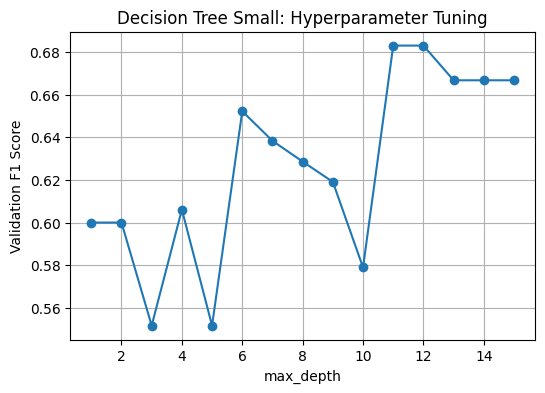

In [13]:
# Modelling Decision Tree Small

# Tune max_depth on validation set
depths = range(1, 16)
val_scores_s = []

for d in depths:
    tree_s = DecisionTreeClassifier(max_depth=d, random_state=0)
    tree_s.fit(X_train_s, y_train_s)
    preds = tree_s.predict(X_val_s)
    val_scores_s.append(f1_score(y_val_s, preds))

# Plot tuning curve
plt.figure(figsize=(6,4))
plt.plot(depths, val_scores_s, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Validation F1 Score")
plt.title("Decision Tree Small: Hyperparameter Tuning")
plt.grid(True)
plt.show()

# Select best depth
best_depth_s = depths[np.argmax(val_scores_s)]
best_depth_s

# Train final Decision Tree Small
dt_small = DecisionTreeClassifier(max_depth=best_depth_s, random_state=0)
dt_small.fit(X_train_s, y_train_s)

y_pred_dt_small = dt_small.predict(X_test_s)


In [14]:
# Compare to logistic regression with same two features

scaler_s = StandardScaler()
X_train_s_scaled = scaler_s.fit_transform(X_train_s)
X_val_s_scaled   = scaler_s.transform(X_val_s)
X_test_s_scaled  = scaler_s.transform(X_test_s)

log_small = LogisticRegression(max_iter=200)
log_small.fit(X_train_s_scaled, y_train_s)

y_pred_log_small = log_small.predict(X_test_s_scaled)


In [15]:
# Metrics Table Small

models_small = {
    "Decision Tree Small": y_pred_dt_small,
    "Logit Small (2 features)": y_pred_log_small
}

results_small = []

for name, preds in models_small.items():
    acc = accuracy_score(y_test_s, preds)
    prec = precision_score(y_test_s, preds)
    rec = recall_score(y_test_s, preds)
    f1 = f1_score(y_test_s, preds)
    fb = fbeta_score(y_test_s, preds, beta=2)
    results_small.append([name, acc, prec, rec, f1, fb])

df_results_small = pd.DataFrame(results_small,
                                columns=["Model", "Accuracy", "Precision", "Recall", "F1", "Fβ (β=2)"])

print(df_results_small)


                      Model  Accuracy  Precision    Recall        F1  Fβ (β=2)
0       Decision Tree Small  0.913706   0.590909  0.619048  0.604651  0.613208
1  Logit Small (2 features)  0.949239   0.866667  0.619048  0.722222  0.656566


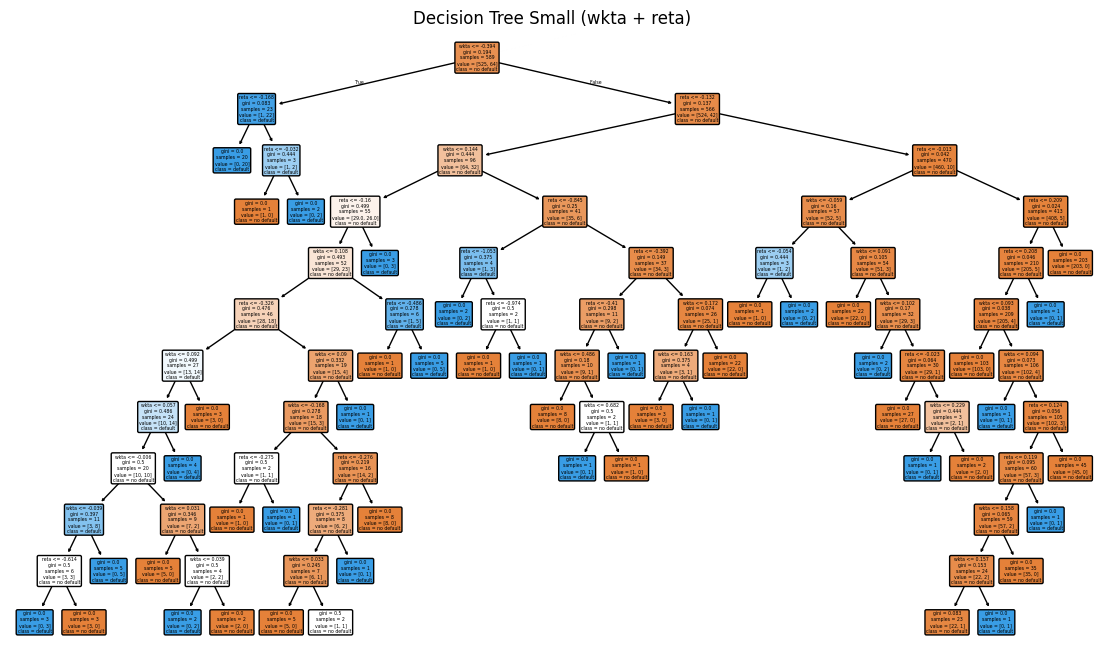

In [167]:
# Plot Final Decision Tree

plt.figure(figsize=(14,8))
plot_tree(dt_small,
          feature_names=['wkta', 'reta'],
          class_names=['no default', 'default'],
          filled=True,
          rounded=True)
plt.title("Decision Tree Small (wkta + reta)")
plt.show()



# Discussion (5 points)

Provide a short discussion about the way we tune the hyperparameters. Pay attention to the charactaristics of the data at hand while answering this question.